# Conditional Generative Adversarial Network(CGAN, pix2pix)
    
        ↪ 조건부 정보(real image / condition image의 쌍)을 입력으로 넣어 조건에 해당하는 결과를 판별하도록 학습함.

#### ▢ Loss
        MSELoss:  discriminator의 예측과 실제 레이블(실제 이미지의 경우 1, 가짜 이미지의 경우 0) 간의 차이를 측정
        L1Loss: 생성된 이미지가 픽셀 수준에서 실제 이미지에 가깝도록 하는 데 사용

#### ▢ GANs의 단점 보완
    (1) Mode Collapse
        ↪ Generator가 다양한 이미지를 생성하지 못하고 비슷한 이미지만 계속 생성해내는 현상. Discriminator를 속이기 쉬운 특정한 레이블(최빈값, mode)만 생성하게 됨.
        CGANs는 조건을 지정하는 학습 데이터가 포함되어 있기 때문에 다양한 출력을 보장함.

    (2) 성능평가
        ↪ GANs의 generator loss는 Discriminator를 속이는 것에만 의존하기 때문에 정량적인 측정이 어렵고 샘플 품질과 직접적인 상관관계가 없음.
        pix2pix와 같은 CGANs는 생성된 이미지와 직접 비교할 수 있는 실제 이미지가 있기 때문에 성능평가가 더 쉬움.

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [ ]:
%%capture
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -O facades.tar.gz
!tar -zxvf facades.tar.gz -C ./

In [ ]:
print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/train/'))[2]))
print("평가 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/val/'))[2]))
print("테스트 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/test/'))[2]))

학습 데이터셋 A와 B의 개수: 400
평가 데이터셋 A와 B의 개수: 100
테스트 데이터셋 A와 B의 개수: 106


이미지 크기: (512, 256)


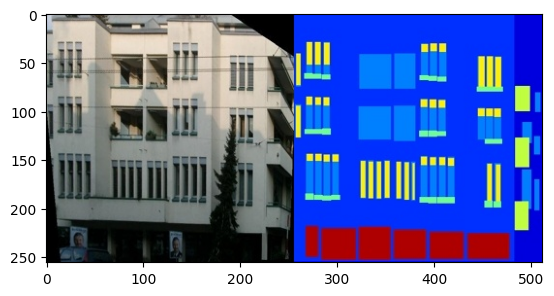

In [ ]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./facades/train/1.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [ ]:
class ImageDataset(Dataset) :
    def __init__(self, root, transforms_=None, mode='train') :
        self.transform = transforms_

        # 경로의 파일을 정렬하여 self.files에 리스트로 만듦
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg"))
        # 데이터의 개수가 적기 때문에 train + test를 train에 사용하고, valid를 test에 사용
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg")))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반

        # data augmentation을 위한 좌우 반전
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("facades", transforms_=transforms_)
val_dataset = ImageDataset("facades", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
temp_A = np.transpose(train_dataset[0]['A'].numpy(), (1, 2, 0))
temp_B = np.transpose(train_dataset[0]['B'].numpy(), (1, 2, 0))

(256, 256, 3)


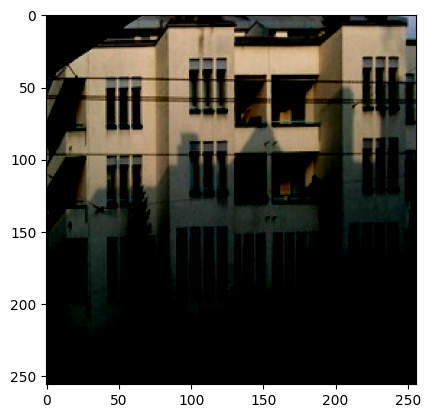

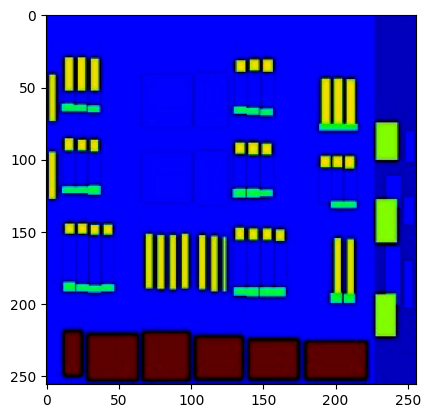

In [ ]:
print(temp_A.shape)
plt.imshow(temp_A)
plt.show()
plt.imshow(temp_B)
plt.show()

In [ ]:
'''
nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)

in_channels, out_channels: 입력 및 출력 채널 크기
kernel_size=4: conv layer의 필터 크기.(4x4)
stride=2: conv layer의 필터가 움직이는 간격(stride=2 : 2칸씩 이동, Conv2d의 경우 가로, 세로를 반으로 축소, ConvTranspose2d의 경우 가로, 세로를 2배 증가)
padding=1: 입력 이미지 가장자리에 추가되는 픽셀 수, 출력 이미지의 크기를 조절하는 기능(padding=1 : 가장자리 1픽셀의 패딩 추가)

'''
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소 (입력 차원: [batch, in_channels, H, W], 출력 차원: [batch, out_channels, H/2, W/2])
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # 입력 차원: [batch, in_channels, H, W], 출력 차원: [batch, out_channels, H/2, W/2]
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가 (입력 차원: [batch, in_channels, H, W], 출력 차원: [batch, out_channels, H*2, W*2])
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        # 입력 차원: [batch, out_channels, H*2, W*2] (x), [batch, skip_channels, H*2, W*2] (skip_input)
        x = self.model(x)
        # 출력 차원: [batch, out_channels+skip_channels, H*2, W*2]
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)
        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256], 입력 이미지의 너비와 높이를 2배로 늘림.
            nn.ZeroPad2d((1, 0, 1, 0)),  # 입력 레이어에 제로패딩 적용. 왼쪽과 위쪽에 1픽셀 늘림
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256], 출력 이미지의 크기 유지
            nn.Tanh(), # 하이퍼볼릭 탄젠트는 각 픽셀 값을 -1에서 1사이로 정규화하므로 데이터 범위를 조절하는데 도움을 줌
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
def show_images_grid(imgs):
    num_images, channels, height, width = imgs.size()

    cols = 8
    rows = int((num_images + cols - 1) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(num_images):
        img = imgs[i].permute(1, 2, 0).clamp(0, 1).to('cpu').numpy() # [0, 1] 범위로 값을 제한
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis('off')

    # 남은 subplot 공간 비활성화
    for j in range(num_images, rows * cols):
        axes[j // cols, j % cols].axis('off')

    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # 평균이 0.0이고 표준 편차가 0.02인 정규 분포를 사용하여 가중치를 초기화
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # 평균이 1.0이고 표준 편차가 0.02인 정규 분포를 사용하여 가중치를 초기화
        torch.nn.init.constant_(m.bias.data, 0.0) # bias를 0.0으로 초기화

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100
n_epochs = 100
lr = 0.0002

# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)
# discriminator는 항상 조건과 이미지를 동시에 받음

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


cuda:0


In [ ]:
import time
start_time = time.time()

for epoch in range(n_epochs):
    generator.train()
    for i, batch in enumerate(train_dataloader):
        real_A = batch["B"].to(device)  # condition ==> A
        real_B = batch["A"].to(device)  # image ==> B

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0).to(device) # 진짜(real): 1
        fake = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0).to(device) # 가짜(fake): 0

        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A) # image ==> B
        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)
        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        if i % 5 == 0 :
            optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        if i % 5 == 0 :
            loss_D.backward()
            optimizer_D.step()

    if (epoch+1) % 10 == 0 :

        print(f"\n[Epoch {epoch+1}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]\n")

        imgs = next(iter(val_dataloader))
        generator.eval()
        with torch.no_grad() :
            real_A = imgs["B"].to(device)
            real_B = imgs["A"].to(device)
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            show_images_grid(img_sample)
        print()


Output hidden; open in https://colab.research.google.com to view.